In [332]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab inline
import pandas as pd
import json
import seaborn as sns
import copy
import os
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
from util import util as util_custom
from util.parser import get_labels,generate_csv,generate_labels,get_sensor_values
import time
from itertools import ifilterfalse
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from itertools import chain
import ast
import tensorflow as tf
import sklearn.preprocessing
from sklearn.manifold import TSNE
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
import keras
from keras.layers import Activation,Dense,Dropout
from keras.models import Sequential
import six
import math
from keras import optimizers
from keras import losses
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from util import visualizer
print(os.getcwd())
print("Imports done ...✈✈✈✈✈✈✈✈ You are free to go.")


Populating the interactive namespace from numpy and matplotlib
/home/cts/Desktop/ML4QS/Assignments/assignments_code_git/assignment3
Imports done ...✈✈✈✈✈✈✈✈ You are free to go.


/home/cts/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'f', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [168]:

def mlp_model1(D,nb_classes=10):
    
    model = Sequential()
    input_shape = (D,)
    print(input_shape,' input dimensions')
    layers = [
        Dense(100,name='fc1',input_shape=input_shape),
        Activation('tanh',name='fc1_act'),
        Dropout(0.5),
        Dense(20,name='fc2'),
        Activation('tanh',name='fc2_act'),
        Dropout(0.5),
        Dense(nb_classes,name='fc_out'),
        Activation('softmax',name='output')
    ]
    for layer in layers:
        print('Added layer:%s'%layer.name)
        model.add(layer)
    print('Initialized model 1')
    return model

def mlp_model2(D,nb_classes=10):
    
    model = Sequential()
    input_shape = (D,)
    print(input_shape,' input dimensions')
    layers = [
        Dense(200,name='fc1',input_shape=input_shape),
        Activation('tanh',name='fc1_act'),
        Dropout(0.3),
        Dense(200,name='fc2'),
        Activation('tanh',name='fc2_act'),
        Dropout(0.3),
        Dense(nb_classes,name='fc_out'),
        Activation('softmax',name='output')
    ]
    for layer in layers:
        print('Added layer:%s'%layer.name)
        model.add(layer)
    print('Initialized model 2')
    return model

def mlp_model3(D,nb_classes=10):
    
    model = Sequential()
    input_shape = (D,)
    print(input_shape,' input dimensions')
    layers = [
        Dense(200,name='fc1',input_shape=input_shape),
        Activation('relu',name='fc1_act'),
        Dense(200,name='fc2'),
        Activation('relu',name='fc2_act'),
        Dense(nb_classes,name='fc_out'),
        Activation('softmax',name='output')
    ]
    for layer in layers:
        print('Added layer:%s'%layer.name)
        model.add(layer)
    print('Initialized model 3')
    return model

def batch_indices(batch_nb, data_length, batch_size):
    """
    This helper function computes a batch start and end index
    :param batch_nb: the batch number
    :param data_length: the total length of the data being parsed by batches
    :param batch_size: the number of inputs in each batch
    :return: pair of (start, end) indices
    """
    # Batch start and end index
    start = int(batch_nb * batch_size)
    end = int((batch_nb + 1) * batch_size)

    # When there are not enough inputs left, we reuse some to complete the
    # batch
    if end > data_length:
        shift = end - data_length
        start -= shift
        end -= shift

    return start, end



def model_argmax(sess, x, predictions, samples):
    """
    Helper function that computes the current class prediction
    :param sess: TF session
    :param x: the input placeholder
    :param predictions: the model's symbolic output
    :param samples: numpy array with input samples (dims must match x)
    :return: the argmax output of predictions, i.e. the current predicted class
    """
    feed_dict = {x: samples}
    probabilities = sess.run(predictions, feed_dict)

    if samples.shape[0] == 1:
        return np.argmax(probabilities)
    else:
        return np.argmax(probabilities, axis=1)



def model_loss(y, model, mean=True):

    op = model.op
    if "softmax" in str(op).lower():
        logits, = op.inputs
    else:
        logits = model

    out = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

    if mean:
        out = tf.reduce_mean(out)
    return out


def model_train(sess, x, y, predictions, X_train, Y_train,args=None,verbose=True):

    
    # Define loss
    loss = model_loss(y, predictions)
    
    train_step = tf.train.AdamOptimizer(learning_rate=args['learning_rate']).minimize(loss)
    train_losses = []
    init = tf.global_variables_initializer()
    sess.run(init)
    with sess.as_default():

        for epoch in six.moves.xrange(args['nb_epochs']):

            nb_batches = int(np.ceil(float(len(X_train)) / args['batch_size']))
            epoch_loss = 0.0
            prev = time.time()
            for batch in range(nb_batches):
                start, end = batch_indices(
                    batch, len(X_train), args['batch_size'])
                cur_batch_size = end - start
                _,batch_loss = sess.run([train_step,loss],feed_dict={x: X_train[start:end],
                                          y: Y_train[start:end]})
                epoch_loss += (cur_batch_size * batch_loss)
            epoch_loss /= nb_batches
            train_losses.append(epoch_loss)
            if verbose and epoch %100 == 0:
                cur = time.time()
                
                print("\tEpoch %d/%d - Loss:%2.6f - Duration:%1.5f seconds" 
                      %(epoch,args['nb_epochs'],epoch_loss,cur-prev))
                
                
        print("\tEpoch %d/%d - Loss:%2.6f - Duration:%1.5f seconds" 
          %(epoch,args['nb_epochs'],epoch_loss,time.time()-prev))
    return train_losses


def data_prepare(dataset,x_columns):
    X = dataset[x_columns].copy()
    y_columns = ['labelstairsdown','labelstairsup','labelwalking']
    Y = dataset[y_columns].copy()
    return X,Y


def model_eval(sess, x, y, model, X_test, Y_test, args=None):
    """
    Compute the accuracy of a TF model on some data
    :param sess: TF session to use when training the graph
    :param x: input placeholder
    :param y: output placeholder (for labels)
    :param model: model output predictions
    :param X_test: numpy array with training inputs
    :param Y_test: numpy array with training outputs
    :param args: dict or argparse `Namespace` object.
                 Should contain `batch_size`
    :return: a float with the accuracy value
    """

    correct_preds = tf.equal(tf.argmax(y, axis=tf.rank(y) - 1),
                                 tf.argmax(model, axis=tf.rank(model) - 1))
    acc_value = tf.reduce_mean(tf.to_float(correct_preds))
    
    # Init result var
    accuracy = 0.0
    preds = np.zeros(Y_test.shape[0])
    with sess.as_default():
        # Compute number of batches
        nb_batches = int(math.ceil(float(len(X_test)) / args['batch_size']))
        assert nb_batches * args['batch_size'] >= len(X_test)

        for batch in range(nb_batches):
            if batch % 100 == 0 and batch > 0:
                print("Batch " + str(batch))

            start = batch * args['batch_size']
            end = min(len(X_test), start + args['batch_size'])
            cur_batch_size = end - start

            cur_acc, cur_preds = sess.run([acc_value, correct_preds],
                                          feed_dict={x: X_test[start:end],
                                                     y: Y_test[start:end]})
            accuracy += (cur_batch_size * cur_acc)
            preds[start:end, ] = cur_preds

        assert end >= len(X_test)

        # Divide by number of examples to get final value
        accuracy /= len(X_test)

    return accuracy, preds

In [166]:
dataset_folder = './datasets'
figures_folder = './figures'
classifier_folder = './classification'
result_dataset_path = './intermediate_datafiles/'
final_dataset_name = 'final_dataset.csv'
files = os.listdir(dataset_folder)
print(files)
csv_dataset_path = os.path.join(dataset_folder,'csv/')
if not os.path.exists(result_dataset_path):
    print('Creating result directory: ' + result_dataset_path)
    os.makedirs(result_dataset_path)
if not os.path.exists(csv_dataset_path):
    print('Creating result directory: ' + csv_dataset_path)
    os.makedirs(csv_dataset_path)
if not os.path.exists(figures_folder):
    print('Creating result directory: ' + figures_folder)
    os.makedirs(figures_folder)
if not os.path.exists(classifier_folder):
    print('Creating result directory: ' + classifier_folder)
    os.makedirs(classifier_folder)

['log_assignment2', 'log_events_assignment3', 'log_assignment3', 'csv', 'log_events_assignment2']


In [169]:
dataset = pd.read_csv(os.path.join(result_dataset_path,final_dataset_name),index_col=0)
print("Dataset size:%d instances - %d features"%(dataset.shape))
features = list(dataset.keys().values)

for i,feat in enumerate(features):
#     print(i,feat)
    pass
normal_features = features[0:10]
kalman_features = features[14:24]
pca_features = features[25:31]
time_domain_features = features[31:86]
freq_domain_features = features[87:]
labels = features[11:14]
print("Normal features length %d"%len(normal_features))
print("Kalman features length %d"%len(kalman_features))
print("PCA features length %d"%len(pca_features))
print("Time domain features length %d"%len(time_domain_features))
print("Frequency Domain features length %d"%len(freq_domain_features))
print("Labels:%s"%str(labels).replace('[','').replace(']',''))

Dataset size:942 instances - 348 features
Normal features length 10
Kalman features length 10
PCA features length 6
Time domain features length 55
Frequency Domain features length 261
Labels:'labelstairsdown', 'labelstairsup', 'labelwalking'


In [275]:
fwd_select = True
max_feats = 50
all_features = list(set().union(normal_features,
                                            pca_features,
                                            time_domain_features, 
                                            freq_domain_features))
prepare = PrepareDatasetForLearning()



# fs = FeatureSelectionClassification()
# if fwd_select:
#     features, ordered_features, ordered_scores = fs.forward_selection(max_feats, X_train[all_features], Y_train)

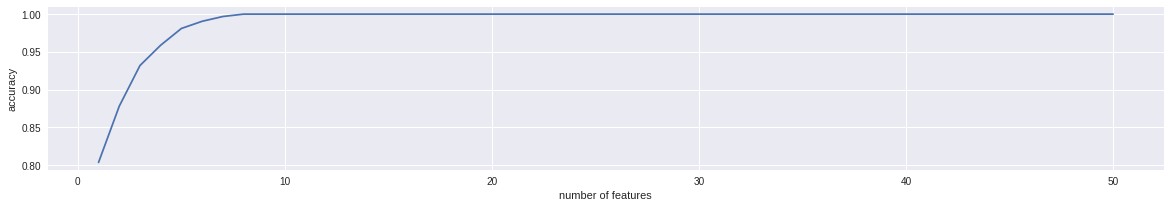

In [287]:
X_train, X_test, Y_train, Y_test = prepare.split_single_dataset_classification(
    dataset, ['label'], 'like', 0.7, filter=True, temporal=False)

rcParams['figure.figsize'] = (20,3)
plt.plot(range(1, max_feats+1), ordered_scores)
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.show()
forward_features = ordered_features
with open('fwd_features.txt','w+') as f:
    for feat in forward_features:
        f.write(feat+'\n')

X_train = X_train[ordered_features].as_matrix()
X_test = X_test[ordered_features].as_matrix()
Y_train[Y_train == 'labelstairsup'] = 0 
Y_train[Y_train == 'labelstairsdown'] = 1
Y_train[Y_train == 'labelwalking'] = 2
Y_test[Y_test == 'labelstairsup'] = 0 
Y_test[Y_test == 'labelstairsdown'] = 1
Y_test[Y_test == 'labelwalking'] = 2

Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)


### Start classifying. Prepare stratified folds 70 % - 30 % cutout.

### Model Preparation

In [288]:
#### NICE SETTING.
classes = Y_train.shape[1]
model = Sequential()
model.add(Dense(200, input_dim=X_train.shape[1],name='fc1')) # X_train.shape[1] == 15 here
model.add(Activation('tanh',name='fc1_out'))
model.add(Dropout(0.5,name='drop1'))
model.add(Dense(200,name='fc2'))
model.add(Activation('tanh',name='fc2_out'))
model.add(Dropout(0.2,name='drop2'))
model.add(Dense(30,name='fc3'))
model.add(Activation('tanh',name='fc3_out'))
model.add(Dense(classes,name='preact_out')) # y_train.shape[1] == 2 here
model.add(Activation('softmax',name='out_layer'))

optim = optimizers.Adam(1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optim,metrics=['accuracy'])


In [289]:
train_history = model.fit(X_train, Y_train, epochs=1000, batch_size=128,verbose=False)
test_loss,acc  = model.evaluate(X_test, Y_test, batch_size=X_test.shape[0])
print('\n',acc)


272/272 [==============================] - 0s

 0.768382370472


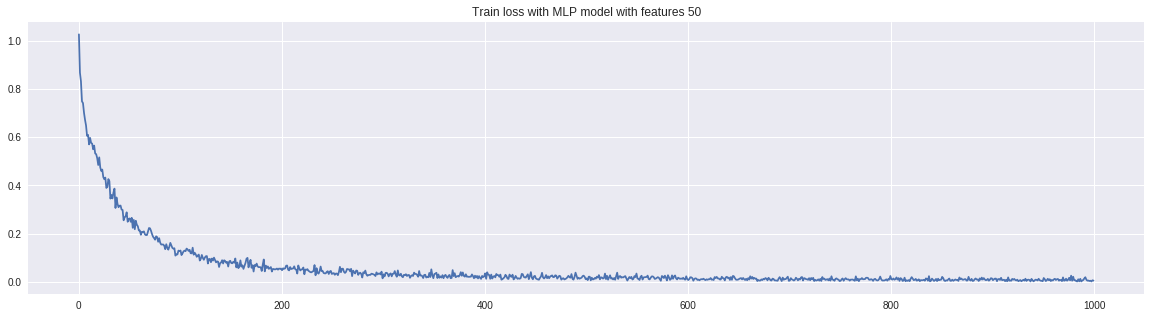

In [334]:
D = X_train.shape[1]
train_losses = train_history.history['loss']
rcParams['figure.figsize'] = (20,5)
plt.plot(train_losses)
plt.title('Train loss with MLP model with features %d'%D)
save_path = os.path.join(classifier_folder,'mlp_model_%d'%D)
if not os.path.exists(save_path):
    os.mkdir(save_path)
plt.savefig(os.path.join(save_path,'mlp_train_loss.png'))


Test accuracy with 50 features returned: 76.838
Saved model to disk
Creating confusion matrix...
Writing confusion matrix to path ./classification/mlp_model_50


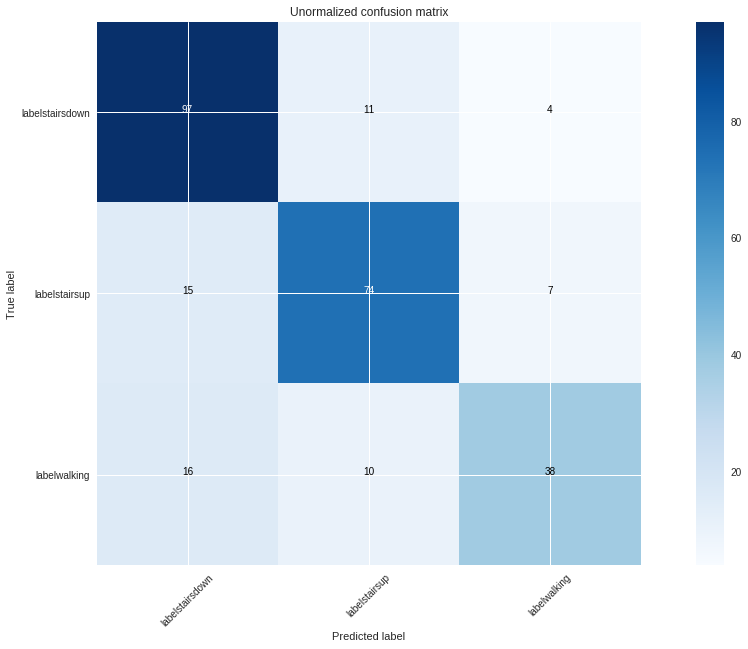

In [335]:
preds = model.predict(X_test)
correct = np.argmax(preds,axis=1) == np.argmax(Y_test,axis=1)
rcParams['figure.figsize'] = (20,10)
out = "Test accuracy with %d features returned: %.3f"%(len(features),acc*100)
print(out)
if not os.path.exists(save_path):
    os.mkdir(save_path)
# serialize model to JSON
model_json = model.to_json()
with open(save_path+"/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_path+"/model.h5")
print("Saved model to disk")
 
visualizer.save_conf_matrix(Y_test,preds,out,path=save_path,classes = labels)

Test accuracy with 50 features returned: 77.574
Creating confusion matrix...
Writing confusion matrix to path ./classification/svm_model_50


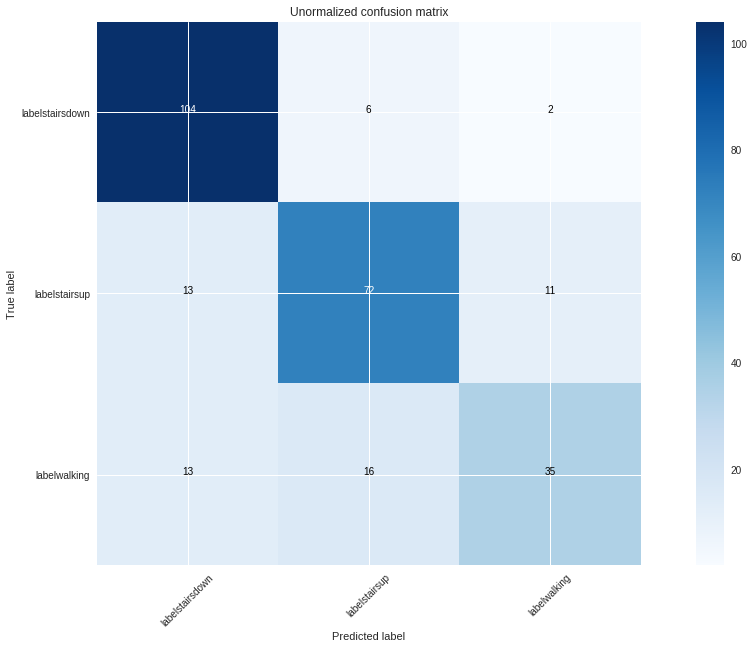

In [296]:
clf = SVC(kernel='linear',verbose=False,max_iter=-1,decision_function_shape='ovr')
clf.fit(X_train,np.argmax(Y_train,axis=1))
svm_acc = clf.score(X_test,np.argmax(Y_test,axis=1))
svm_predictions = clf.predict(X_test)
out = "Test accuracy with %d features returned: %.3f"%(len(features),svm_acc*100)
print(out)
save_path = os.path.join(classifier_folder,'svm_model_%d'%D)

if not os.path.exists(save_path):
    os.mkdir(save_path)
svm_preds = lb.transform(svm_predictions)
visualizer.save_conf_matrix(Y_test,svm_preds,out,path=save_path,classes = labels)

### Feature extraction

In [345]:
fc3_extract = Sequential()
for layer in model.layers[:-2]:
    print(layer.name)
    fc3_extract.add(layer)
classes = ['stairs up','stairs down','walking']
colors = plt.get_cmap('gist_ncar')(np.linspace(0, 0.8,len(classes)))
markers = ['^','v','.']

fc1
fc1_out
drop1
fc2
fc2_out
drop2
fc3
fc3_out


In [356]:
def visualize(features,labels,filename = 'tsne.png',annotate=False,plot_only = 1000,load=False,classes=np.arange(10)):
    assert features.shape[0] >= len(labels), "More labels than weights"
    print('Plotting features of dimensionality:%d'%features.shape[1])
    print('Saving to filename: %s'%filename)
    projections_file = 'features_2d.npy'
    tsne = TSNE(perplexity=50, n_components=2, n_iter=5000,verbose=False)
    projection_2d = tsne.fit_transform(features)
    print('fitting features complete...')
    np.save(projections_file,projection_2d)
    plt.figure(figsize=(10, 10))  #in inches
    xx = np.arange(len(classes))
    tt = np.random.randn(len(classes))
    print('plotting features ...',projection_2d.shape)
    for i in range(xx.shape[0]):
        proxy = plt.scatter(xx[i],tt[i],
            color=colors[i],
            marker=markers[i],s=10,
            label=classes[i])
    for i,label in enumerate(labels):
        x = projection_2d[i,0]
        y = projection_2d[i,1]
        plt.scatter(x, y ,color = colors[label],s=30,marker=markers[label])
        if annotate:
            plt.annotate(classes[label],xy=(x, y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.legend(classes)
    plt.savefig(filename)
    plt.show()


(272, 30)
Plotting features of dimensionality:50
Saving to filename: ./classification/mlp_model_50/tsne.png
fitting features complete...
plotting features ... (272, 2)


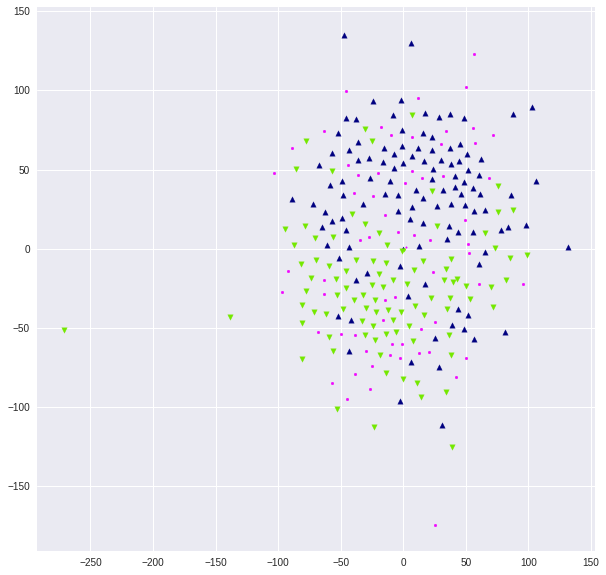

In [357]:
fc3_extract.compile(loss='categorical_crossentropy', optimizer=optim,metrics=['accuracy'])
fc3_features = fc3_extract.predict(X_test)
fc3_features_train = fc3_extract.predict(X_train)
print(fc3_features.shape)
plot_only = fc3_features.shape[0]

visualize(X_test,np.argmax(Y_test,axis=1),classes= classes,annotate=False,filename=save_path+'/tsne.png',plot_only=plot_only,load=True)

In [ ]:
clf = SVC(kernel='linear',verbose=False,max_iter=-1,decision_function_shape='ovr')
clf.fit(fc3_features_train,np.argmax(Y_train,axis=1))
svm_acc = clf.score(fc3_features,np.argmax(Y_test,axis=1))
svm_predictions = clf.predict(fc3_features)
out = "Test accuracy with %d features returned: %.3f"%(len(features),svm_acc*100)
print(out)
save_path = os.path.join(classifier_folder,'svm_model_fe_%d'%D)

if not os.path.exists(save_path):
    os.mkdir(save_path)
svm_preds = lb.transform(svm_predictions)
visualizer.save_conf_matrix(Y_test,svm_preds,out,path=save_path,classes = labels)